In [1]:
import numpy as np
import pandas as pd
import opendp.smartnoise.core as sn
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import theano
from sklearn.feature_selection import mutual_info_regression

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
## opendp program
@theano.compile.ops.as_op(itypes=[tt.lvector,tt.lvector,tt.lvector,
                                  tt.lvector,tt.dvector,tt.lvector,
                                  tt.lscalar],
                          otypes=[tt.dscalar])
def dp_program(age,sex,educ,race,income,married,N):
    temp_file='temp.csv'    
    var_names = ["age", "sex", "educ", "race", "income", "married"]
    data = {
        "age":     age,
        "sex":     sex,
        "educ":    educ,
        "race":    race,
        "income":  income,
        "married": married
    }
    df = pd.DataFrame(data,columns=var_names)
    df.to_csv(temp_file)
    with sn.Analysis() as analysis:
        # load data
        data = sn.Dataset(path=temp_file,column_names=var_names)

        # get mean of age
        age_mean = sn.dp_mean(data = sn.to_float(data['income']),
                              privacy_usage = {'epsilon': .1},
                              data_lower = 0., # min income
                              data_upper = 200., # max income                   
                              data_rows = N
                             )
    analysis.release()
    return np.float64(age_mean.value)    

In [3]:
with pm.Model() as model:
    
    # Dataset size
    N = 10
    N_rv = pm.Constant('N',N)
    
    # Attribute specs
    age     = pm.DiscreteUniform("age",0,150,shape=N)
    sex     = pm.DiscreteUniform("sex",0,2,shape=N)
    educ    = pm.DiscreteUniform("educ",0,10,shape=N)
    race    = pm.DiscreteUniform("race",0,50,shape=N)
    income  = pm.Normal("income", mu=100,sigma=5,shape=N)
    married = pm.DiscreteUniform("married",0,1,shape=N)
    
    pm.Deterministic("output",dp_program(age,sex,educ,race,income,married,N_rv))
    
    trace=pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [race]
>>Metropolis: [educ]
>>Metropolis: [sex]
>>Metropolis: [age]
>>Metropolis: [N]
>NUTS: [income]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 162 seconds.
/home/pardo/.local/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
The estimated number of effective samples is smaller than 200 for some parameters.


In [4]:
print("Mutual information between sex and income, and race and income")
[(vm,[mutual_info_regression(trace[vm][:,i].reshape(-1,1),trace['income'][:,i]) for i in range(0,1)]) for vm in ['sex','race']]

Mutual information between sex and income, and race and income


[('sex', [array([0.02276908])]), ('race', [array([0.03053039])])]

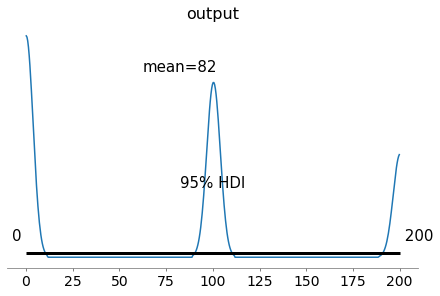

In [5]:
with model:
    az.plot_posterior(az.from_pymc3(trace),var_names=['output'],hdi_prob=.95)